### Ali Darabi - 810100264
### Hesam Ramezanian - 810100248

# Data Science - Project Phase 2

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import math
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tqdm.keras import TqdmCallback 
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import warnings

c:\Users\alida\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("P1-Data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316397 entries, 0 to 316396
Data columns (total 24 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Lng                  316397 non-null  float64
 1   Lat                  316397 non-null  float64
 2   Cid                  316397 non-null  int64  
 3   followers            316397 non-null  int64  
 4   totalPrice           316397 non-null  float64
 5   price                316397 non-null  int64  
 6   square               316397 non-null  float64
 7   livingRoom           316397 non-null  int64  
 8   drawingRoom          316397 non-null  int64  
 9   kitchen              316397 non-null  int64  
 10  bathRoom             316397 non-null  int64  
 11  buildingType         316397 non-null  float64
 12  constructionTime     316397 non-null  int64  
 13  renovationCondition  316397 non-null  int64  
 14  buildingStructure    316397 non-null  int64  
 15  ladderRatio      

<span style="color: cyan;">We create the following columns in the EDA part: `tradeTimeYear`, `tradeTimeMonth`, and `floorNumber`.</span>

## <span style="color: orange;">**Part 1: Preprocessing**</span>

<span style="color: cyan;">**We did most of the preprocessing in Phase One.**</span>

In [3]:
colToRemove = ['ladderRatio', 'tradeTimeMonth', 'Cid']
df = df.drop(colToRemove, axis=1)

<span style="color: cyan;">We drop these columns because they have zero correlation with our target column.</span>

In [4]:
df = df.drop('totalPrice', axis=1)

<span style="color: cyan;">We drop the `totalPrice` column because we can infer our target column from this column.</span>

In [5]:
def removeOutliersIQR(column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lowerBound = Q1 - 1.5 * IQR
    upperBound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lowerBound) | (df[column] > upperBound)]
    print(f"Number of outliers in '{column}': {len(outliers)}")
    dfCleaned = df[~((df[column] < lowerBound) | (df[column] > upperBound))]
    return dfCleaned

In [6]:
df = removeOutliersIQR('price')
df = removeOutliersIQR('communityAverage')

Number of outliers in 'price': 11545
Number of outliers in 'communityAverage': 6778


<span style="color: cyan;">We drop outliers in the `price` and `communityAverage` columns because they might cause our model to have high variance in the future.</span>

In [7]:
columnsToStandardize = df.columns.difference(['Lat', 'Lng'])
scaler = StandardScaler()
scaler.fit(df[columnsToStandardize])
df[columnsToStandardize] = scaler.transform(df[columnsToStandardize])

<span style="color: cyan;">We standardize our data to ensure that all features are on the same scale, which helps algorithms converge faster and prevents features with larger magnitudes from dominating those with smaller magnitudes during model training.</span>

## <span style="color: orange;">**Part 2: Feature Engineering and Selection**</span>

In [8]:
quantiles = df['price'].quantile([0.33, 0.66])
def classifyPrice(price):
    if price <= quantiles[0.33]:
        return 'Low'
    elif price <= quantiles[0.66]:
        return 'Medium'
    else:
        return 'High'
df['PriceClass'] = df['price'].apply(classifyPrice)

<span style="color:cyan">We created a new column called `PriceClass` because our target column needs to be categorical for classification models.</span>

In [9]:
targetColumn = 'price'
X = df.drop(columns=[targetColumn])  
y = df[targetColumn]  
XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=0.1, random_state=32)
trainDf = pd.concat([XTrain, yTrain], axis=1)
testDf = pd.concat([XTest, yTest], axis=1)

In [10]:
trainDataPriceClass = trainDf['PriceClass']
testDataPriceClass = testDf['PriceClass']
trainDf = trainDf.drop('PriceClass', axis=1)
testDf = testDf.drop('PriceClass', axis=1)
XTrain = XTrain.drop('PriceClass', axis=1)
XTest = XTest.drop('PriceClass', axis=1)

In [11]:
def runLinearRegression(XTrain, XTest, yTrain, yTest):  
    model = LinearRegression()
    model.fit(XTrain, yTrain)
    yPred = model.predict(XTest)
    r2 = r2_score(yTest, yPred)
    rmse = math.sqrt(mean_squared_error(yTest, yPred))
    print("R2 Score:", r2)
    print("RMSE:", rmse)

In [12]:
runLinearRegression(XTrain, XTest, yTrain, yTest)

R2 Score: 0.7572994253126245
RMSE: 0.4882987274090942


<span style="color: cyan;">We train a regression model and calculate RMSE and R2 score before feature engineering so we can compare results afterward.</span>

In [13]:
avgLng = 116.4074
avgLat = 39.9042

def haversineFormula(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    r = 6371
    return 1/(1+(c * r))

trainDf['distanceToCenter'] = trainDf.apply(lambda row: haversineFormula(row['Lng'], row['Lat'], avgLng, avgLat), axis=1)
testDf['distanceToCenter'] = testDf.apply(lambda row: haversineFormula(row['Lng'], row['Lat'], avgLng, avgLat), axis=1)
colToRemove = ['Lng', 'Lat']
trainDf = trainDf.drop(colToRemove, axis=1)
testDf = testDf.drop(colToRemove, axis=1)

<span style="color:cyan">Based on the previous phase, we understand that there is a relationship between house prices and the distance to the city center. Therefore, we created a new column called `distanceToCenter`.</span>

In [14]:
medianPrices = trainDf.groupby('district')['price'].median().sort_values()
districtLevel = medianPrices.reset_index().reset_index().rename(columns={'index': 'districtLevel'})
trainDf = trainDf.merge(districtLevel[['district', 'districtLevel']], on='district', how='left')
testDf = testDf.merge(districtLevel[['district', 'districtLevel']], on='district', how='left')
trainDf

,followers,square,livingRoom,drawingRoom,kitchen,bathRoom,buildingType,constructionTime,renovationCondition,buildingStructure,elevator,fiveYearsProperty,subway,district,communityAverage,tradeTimeYear,floorNumber,price,distanceToCenter,districtLevel
0,-0.421912,-0.166916,-1.313392,-0.338683,0.052225,-0.440956,-1.571416,0.054549,-1.209114,0.797615,0.841453,-1.352681,0.830900,0.113412,0.108841,-1.051244,2.353706,0.039759,0.091180,9
1,-0.392354,1.106654,1.293347,1.572176,0.052225,1.897958,0.785036,0.766980,1.069568,0.797615,-1.188421,0.739273,0.830900,-0.247828,-1.011557,0.162215,-0.949416,-0.913137,0.048354,5
2,-0.067219,1.170736,1.293347,1.572176,0.052225,1.897958,-0.000448,0.766980,-1.209114,0.797615,0.841453,0.739273,-1.203515,0.113412,-0.141311,0.768944,1.718490,-0.226529,0.088598,9
3,-0.362796,-0.765669,-0.010022,-0.338683,0.052225,-0.440956,0.785036,-0.895360,0.310007,-1.314929,-1.188421,0.739273,0.830900,0.835892,-0.690854,0.162215,-0.949416,-0.597450,0.060895,7
4,-0.096777,-0.242700,-0.010022,-0.338683,0.052225,-0.440956,0.785036,0.885719,1.069568,0.797615,0.841453,0.739273,0.830900,0.474652,0.575416,0.768944,0.575102,1.090296,0.055900,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268261,-0.185450,-0.862350,-1.313392,-0.338683,0.052225,-0.440956,-0.000448,0.648242,1.069568,0.797615,0.841453,0.739273,-1.203515,-1.692788,-0.183554,0.162215,1.083275,-0.641591,0.131270,8
268262,-0.481027,-1.251582,-1.313392,-0.338683,0.052225,-0.440956,-1.571416,-1.964007,-1.209114,-1.314929,0.841453,0.739273,0.830900,1.197132,2.518991,-1.657973,0.321016,0.688754,0.159946,12
268263,0.908185,-0.811363,-0.010022,-0.338683,0.052225,-0.440956,0.785036,-1.132837,0.310007,-1.314929,-1.188421,0.739273,-1.203515,0.474652,0.470215,1.375674,-0.949416,1.474563,0.078608,10
268264,-0.451469,-1.076609,-1.313392,-0.338683,0.052225,-0.440956,0.785036,-1.014098,-1.209114,-1.314929,-1.188421,0.739273,0.830900,0.113412,0.657788,-0.444514,-0.949416,0.483997,0.089898,9


<span style="color:cyan">According to the previous phase, we understand that there is a relationship between house prices and the district they are in. Therefore, we sorted districts according to the median price and created a new column called `districtLevel`.</span>

In [15]:
corrMatrix = trainDf.corr()
fig = go.Figure(data=go.Heatmap(
                   z=corrMatrix.values,
                   x=corrMatrix.columns,
                   y=corrMatrix.index,
                   colorscale='Viridis',
                   text=corrMatrix.values,
                   texttemplate="%{text:.2f}",
                   textfont={"size":10}))

price_column_index = list(corrMatrix.columns).index('price')
price_row_index = list(corrMatrix.index).index('price')
fig.update_layout(
    title='Correlation Matrix',
    xaxis_nticks=36,
    width=1000,
    height=1000,
    autosize=True,
    margin=dict(l=100, r=100, t=100, b=100),
    shapes=[
        go.layout.Shape(
            type="rect",
            x0=price_column_index - 0.5,  
            y0=-0.5,                      
            x1=price_column_index + 0.5,  
            y1=len(corrMatrix.index) - 0.5, 
            line=dict(
                color="red",
                width=3
            )
        ),
        go.layout.Shape(
            type="rect",
            x0=-0.5,                      
            y0=price_row_index - 0.5,     
            x1=len(corrMatrix.columns) - 0.5,  
            y1=price_row_index + 0.5,     
            line=dict(
                color="red",
                width=3
            )
        )
    ]
)
fig.show()

In [16]:
runLinearRegression(trainDf.drop(columns=[targetColumn]), testDf.drop(columns=[targetColumn]), 
                    trainDf[targetColumn], testDf[targetColumn])

R2 Score: 0.7581610983219744
RMSE: 0.4874311399401236


<span style="color: cyan;">As you can see, after feature engineering, our R2 score increased slightly.</span>

## <span style="color: orange;">**Part 3: Dimensionality Reduction**</span>

In [17]:
trainDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268266 entries, 0 to 268265
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   followers            268266 non-null  float64
 1   square               268266 non-null  float64
 2   livingRoom           268266 non-null  float64
 3   drawingRoom          268266 non-null  float64
 4   kitchen              268266 non-null  float64
 5   bathRoom             268266 non-null  float64
 6   buildingType         268266 non-null  float64
 7   constructionTime     268266 non-null  float64
 8   renovationCondition  268266 non-null  float64
 9   buildingStructure    268266 non-null  float64
 10  elevator             268266 non-null  float64
 11  fiveYearsProperty    268266 non-null  float64
 12  subway               268266 non-null  float64
 13  district             268266 non-null  float64
 14  communityAverage     268266 non-null  float64
 15  tradeTimeYear    

In [18]:
numericalColumnsList = ['followers', 'square', 'constructionTime', 'communityAverage', 'tradeTimeYear', 'floorNumber', 'distanceToCenter']

In [19]:
numericFeaturesTrain = trainDf[numericalColumnsList]
numericFeaturesTest = testDf[numericalColumnsList]

pca = PCA(n_components=2)
pca.fit(numericFeaturesTrain)
trainDfPca = pca.transform(numericFeaturesTrain)
testDfPca = pca.transform(numericFeaturesTest)

varianceExplained = pca.explained_variance_ratio_
cumulativeVarianceExplained = np.cumsum(varianceExplained)

print("Cumulative Variance Explained by Principal Components:")
print(cumulativeVarianceExplained)


print("Minimum number of dimensions to retain 95% of the variance:", 6)

Cumulative Variance Explained by Principal Components:
[0.27454701 0.50881583]
Minimum number of dimensions to retain 95% of the variance: 6


<span style="color: cyan;">The minimum number of dimensions to retain 95% of the variance is 6, which retains about 99% of the variance. With 2 dimensions, only about 51% of the variance will be retained.</span>

In [20]:
trainDfPca = pd.concat([trainDf.drop(columns=numericalColumnsList), pd.DataFrame(trainDfPca, columns=['PCA1', 'PCA2'])], axis=1)
testDfPca = pd.concat([testDf.drop(columns=numericalColumnsList), pd.DataFrame(testDfPca, columns=['PCA1', 'PCA2'])], axis=1)
trainDfPca

,livingRoom,drawingRoom,kitchen,bathRoom,buildingType,renovationCondition,buildingStructure,elevator,fiveYearsProperty,subway,district,price,districtLevel,PCA1,PCA2
0,-1.313392,-0.338683,0.052225,-0.440956,-1.571416,-1.209114,0.797615,0.841453,-1.352681,0.830900,0.113412,0.039759,9,0.818446,-1.286175
1,1.293347,1.572176,0.052225,1.897958,0.785036,1.069568,0.797615,-1.188421,0.739273,0.830900,-0.247828,-0.913137,5,0.940361,-0.118847
2,1.293347,1.572176,0.052225,1.897958,-0.000448,-1.209114,0.797615,0.841453,0.739273,-1.203515,0.113412,-0.226529,9,2.022788,0.092548
3,-0.010022,-0.338683,0.052225,-0.440956,0.785036,0.310007,-1.314929,-1.188421,0.739273,0.830900,0.835892,-0.597450,7,-1.191167,0.201570
4,-0.010022,-0.338683,0.052225,-0.440956,0.785036,1.069568,0.797615,0.841453,0.739273,0.830900,0.474652,1.090296,10,0.656674,0.288694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
268261,-1.313392,-0.338683,0.052225,-0.440956,-0.000448,1.069568,0.797615,0.841453,0.739273,-1.203515,-1.692788,-0.641591,8,0.549222,-0.064737
268262,-1.313392,-0.338683,0.052225,-0.440956,-1.571416,-1.209114,-1.314929,0.841453,0.739273,0.830900,1.197132,0.688754,12,-2.773631,-1.517983
268263,-0.010022,-0.338683,0.052225,-0.440956,0.785036,0.310007,-1.314929,-1.188421,0.739273,-1.203515,0.474652,1.474563,10,-1.489801,1.800434
268264,-1.313392,-0.338683,0.052225,-0.440956,0.785036,-1.209114,-1.314929,-1.188421,0.739273,0.830900,0.113412,0.483997,9,-1.913621,-0.385912


## <span style="color: orange;">**Part 4: Evaluation Metric**</span>

In [21]:
runLinearRegression(trainDf.drop(columns=[targetColumn]), testDf.drop(columns=[targetColumn]), 
                    trainDf[targetColumn], testDf[targetColumn])

R2 Score: 0.7581610983219744
RMSE: 0.4874311399401236


<span style="color: cyan;"> 
In regression problems like predicting house prices, R-squared (R²) and Root Mean Squared Error (RMSE) are essential evaluation metrics.

1. **R-squared (R²) Score**: Measures the proportion of variance in house prices explained by features. Ranges from 0 to 1; higher values indicate better fit.

2. **Root Mean Squared Error (RMSE)**: Gives the average magnitude of prediction errors. Lower values indicate better model performance.

Both metrics offer insights: R² assesses overall model fit, while RMSE quantifies prediction accuracy.

Using R² and RMSE together provides a comprehensive understanding of model performance. High R² and low RMSE signify a well-performing model, explaining much variance with small errors.

</span>

<span style="color:cyan">

Because we want to run classification models on our data set as well, we used classification metrics like accuracy, F1 score, precision, and recall in these models.

- **Accuracy** measures the proportion of correctly classified instances out of the total instances.
- **F1 Score** is the harmonic mean of precision and recall, providing a balance between the two, especially useful in cases of class imbalance.
- **Precision** indicates the proportion of true positive predictions among all positive predictions, showing how many of the predicted positive cases are actually positive.
- **Recall** (or sensitivity) measures the proportion of actual positives that were correctly identified by the model, showing how well the model captures all the positive cases.

</span>

## <span style="color: orange;">**Part 5: Model Training**</span>

### <span style="color: pink;">**Method One: Neural Network**</span>

In [22]:
def trainAndEvaluateCNNModel(XTrain, XTest, yTrain, yTest):
    warnings.filterwarnings("ignore")
    model = Sequential([
        Dense(128, kernel_initializer='normal', activation='relu', input_shape=(XTrain.shape[1],)),
        Dense(64, kernel_initializer='normal', activation='relu'),
        Dense(32, kernel_initializer='normal', activation='relu'),
        Dense(1, kernel_initializer='normal')  
    ])
    model.compile(optimizer=Adam(), loss='mean_squared_error')
    history = model.fit(XTrain, yTrain, validation_data=(XTest, yTest), epochs=100, batch_size=32, verbose=0, callbacks=[TqdmCallback()])
    plt.plot(history.history['loss'], label='Training Error')
    plt.plot(history.history['val_loss'], label='Validation Error')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error')
    plt.title('Training Error Plot')
    plt.legend()
    plt.show()
    loss = model.evaluate(XTest, yTest)
    print("Test Loss (Mean Squared Error):", loss)
    yPred = model.predict(XTest)
    r2 = r2_score(yTest, yPred)
    print("R-squared (R²) Score:", r2)

100%|██████████| 100/100 [07:03<00:00,  4.23s/epoch, loss=0.113, val_loss=0.122]


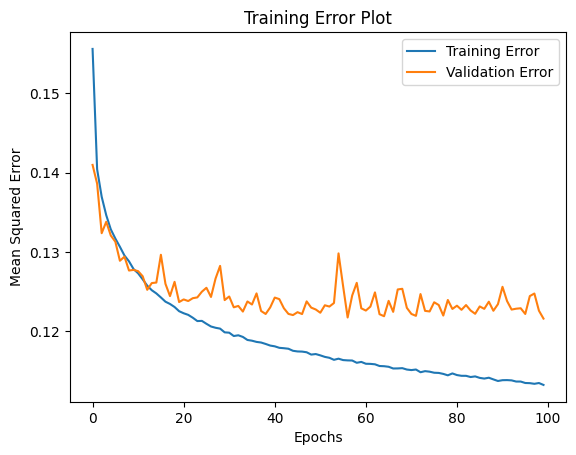

932/932 ━━━━━━━━━━━━━━━━━━━━ 0s 333us/step - loss: 0.1200
Test Loss (Mean Squared Error): 0.12159360945224762
932/932 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step
R-squared (R²) Score: 0.8762314086970017


In [23]:
trainAndEvaluateCNNModel(trainDf.drop(columns=[targetColumn]), testDf.drop(columns=[targetColumn]), trainDf[targetColumn], testDf[targetColumn])

100%|██████████| 100/100 [07:02<00:00,  4.23s/epoch, loss=0.298, val_loss=0.317]


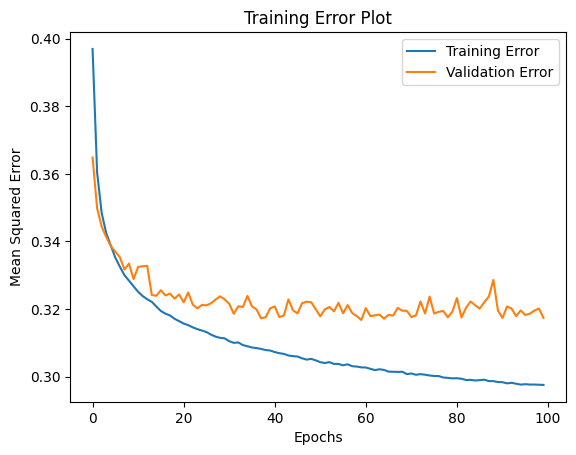

932/932 ━━━━━━━━━━━━━━━━━━━━ 0s 335us/step - loss: 0.3233
Test Loss (Mean Squared Error): 0.31738418340682983
932/932 ━━━━━━━━━━━━━━━━━━━━ 0s 408us/step
R-squared (R²) Score: 0.6769386214987123


In [24]:
trainAndEvaluateCNNModel(trainDfPca.drop(columns=[targetColumn]), testDfPca.drop(columns=[targetColumn]), trainDfPca[targetColumn], testDfPca[targetColumn])

<span style="color: cyan;"> 

**Network Architecture**:
- **Layers**: The model consists of three hidden layers with 128, 64, and 32 neurons respectively, all using ReLU activation. The input layer matches the shape of the training data, and the output layer has a single neuron for regression.
- **Reason**: This architecture is chosen to progressively reduce the complexity and extract meaningful patterns from the data for predicting a continuous target.

**Loss Function**:
- **Type**: Mean Squared Error (MSE)
- **Reason**: MSE is ideal for regression tasks as it penalizes larger errors more, thus providing a clear measure of how well the model's predictions match the actual values.

**Optimization Algorithm**:
- **Type**: Adam (Adaptive Moment Estimation)
- **Reason**: Adam is selected for its efficiency and ability to handle sparse gradients, making it suitable for training deep networks with varying learning rates.

</span>

<span style="color:cyan;">As you can see, the result of the CNN model for the dataframe with PCA is much lower than for the original dataframe. This might be because with 2 principal components, it only retains 51% of the variance, and to retain 95% of the variance, we need 6 principal components.</span>


### <span style="color: pink;">**Methods Two & Three**</span>

In [25]:
runLinearRegression(trainDf.drop(columns=[targetColumn]), testDf.drop(columns=[targetColumn]), trainDf[targetColumn], testDf[targetColumn])

R2 Score: 0.7581610983219744
RMSE: 0.4874311399401236


In [26]:
runLinearRegression(trainDfPca.drop(columns=[targetColumn]), testDfPca.drop(columns=[targetColumn]), trainDfPca[targetColumn], testDfPca[targetColumn])

R2 Score: 0.5158396184576882
RMSE: 0.6896755253778938


<span style="color:cyan;">As you can see, the result of Linear Regression for the dataframe with PCA is much lower than for the original dataframe. This might be because with 2 principal components, it only retains 51% of the variance, and to retain 95% of the variance, we need 6 principal components.</span>

In [27]:
def trainXgboostRegressor(XTrain, XTest, yTrain, yTest):
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.2)
    model.fit(XTrain, yTrain)
    yPred = model.predict(XTest)
    mse = mean_squared_error(yTest, yPred)
    rmse = mse ** 0.5
    r2 = r2_score(yTest, yPred)
    print(f"R-squared (R²) Score: {r2:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

In [28]:
trainXgboostRegressor(trainDf.drop(columns=[targetColumn]), testDf.drop(columns=[targetColumn]), trainDf[targetColumn], testDf[targetColumn])

R-squared (R²) Score: 0.8973
Root Mean Squared Error (RMSE): 0.3176


In [29]:
trainXgboostRegressor(trainDfPca.drop(columns=[targetColumn]), testDfPca.drop(columns=[targetColumn]), trainDfPca[targetColumn], testDfPca[targetColumn])

R-squared (R²) Score: 0.6807
Root Mean Squared Error (RMSE): 0.5601


<span style="color:cyan;">

**n_estimators**=1000: This means the model uses 1000 trees. More trees generally help capture complex patterns in the data, improving the model's performance.

**learning_rate=0.2**: This means each tree's contribution is relatively large, allowing the model to learn faster.
Combined Effect: The high number of trees with a moderately high learning rate creates a balance. The model learns quickly and captures detailed patterns without overfitting too much. This combination often results in a strong and well-generalized model.

</span>

<span style="color:cyan;">As you can see, the result of XGBoost Regressor for the dataframe with PCA is much lower than for the original dataframe. This might be because with 2 principal components, it only retains 51% of the variance, and to retain 95% of the variance, we need 6 principal components.</span>

In [30]:
def runDecisionTree(XTrain, XTest, yTrain, yTest):
    model = DecisionTreeClassifier(random_state=17, max_depth=20, min_samples_leaf=20, min_samples_split=2, criterion='entropy')
    model.fit(XTrain, yTrain)
    yTrainPred = model.predict(XTrain)
    yTestPred = model.predict(XTest)
    
    trainAccuracy = accuracy_score(yTrain, yTrainPred)
    trainPrecision = precision_score(yTrain, yTrainPred, average='weighted')
    trainRecall = recall_score(yTrain, yTrainPred, average='weighted')
    trainF1 = f1_score(yTrain, yTrainPred, average='weighted')
    
    testAccuracy = accuracy_score(yTest, yTestPred)
    testPrecision = precision_score(yTest, yTestPred, average='weighted')
    testRecall = recall_score(yTest, yTestPred, average='weighted')
    testF1 = f1_score(yTest, yTestPred, average='weighted')
    
    print("Training Metrics:")
    print(f"Accuracy: {trainAccuracy:.2f}")
    print(f"Precision: {trainPrecision:.2f}")
    print(f"Recall: {trainRecall:.2f}")
    print(f"F1 Score: {trainF1:.2f}")
    print("\nTest Metrics:")
    print(f"Accuracy: {testAccuracy:.2f}")
    print(f"Precision: {testPrecision:.2f}")
    print(f"Recall: {testRecall:.2f}")
    print(f"F1 Score: {testF1:.2f}")
    print("\nClassification Report (Test Data):")
    print(classification_report(yTest, yTestPred))
    print("Confusion Matrix (Test Data):")
    print(confusion_matrix(yTest, yTestPred))

In [31]:
def plotErrorDecisionTree(XTrain, XTest, yTrain, yTest):
    trainErrors = []
    testErrors = []
    maxDepths = range(1, 21)
    for depth in maxDepths:
        model = DecisionTreeClassifier(max_depth=depth, random_state=17)
        model.fit(XTrain, yTrain)
        train_accuracy = accuracy_score(yTrain, model.predict(XTrain))
        test_accuracy = accuracy_score(yTest, model.predict(XTest))
        trainErrors.append(1 - train_accuracy)
        testErrors.append(1 - test_accuracy)
    plt.figure(figsize=(10, 6))
    plt.plot(maxDepths, trainErrors, label="Training Error")
    plt.plot(maxDepths, testErrors, label="Test Error")
    plt.xlabel("Maximum Depth")
    plt.ylabel("Error Rate")
    plt.title("Training and Test Error vs Maximum Depth")
    plt.legend()
    plt.show()

Training Metrics:
Accuracy: 0.86
Precision: 0.86
Recall: 0.86
F1 Score: 0.86

Test Metrics:
Accuracy: 0.82
Precision: 0.83
Recall: 0.82
F1 Score: 0.82

Classification Report (Test Data):
              precision    recall  f1-score   support

        High       0.86      0.86      0.86      9974
         Low       0.87      0.86      0.87      9891
      Medium       0.74      0.75      0.74      9943

    accuracy                           0.82     29808
   macro avg       0.83      0.82      0.82     29808
weighted avg       0.83      0.82      0.82     29808

Confusion Matrix (Test Data):
[[8611   38 1325]
 [  55 8552 1284]
 [1340 1185 7418]]


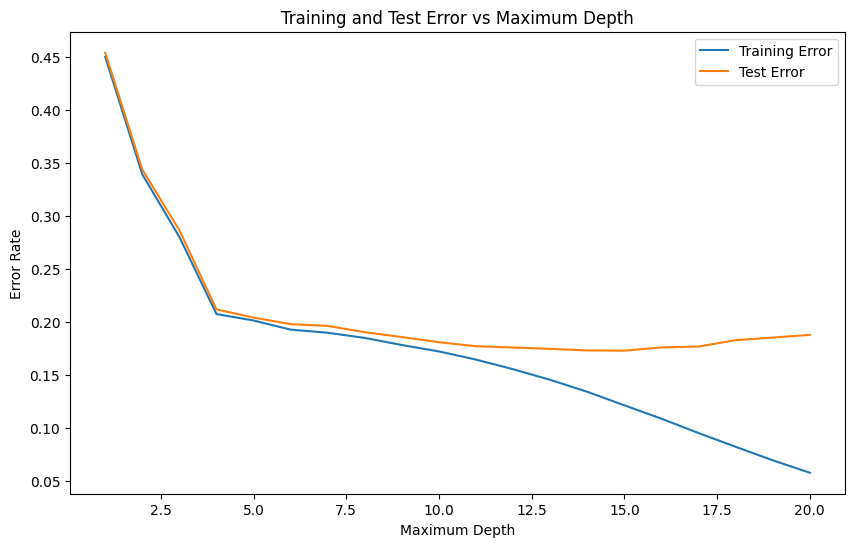

In [32]:
runDecisionTree(trainDf.drop(columns=[targetColumn]), testDf.drop(columns=[targetColumn]), trainDataPriceClass, testDataPriceClass)
plotErrorDecisionTree(trainDf.drop(columns=[targetColumn]), testDf.drop(columns=[targetColumn]), trainDataPriceClass, testDataPriceClass)

Training Metrics:
Accuracy: 0.76
Precision: 0.76
Recall: 0.76
F1 Score: 0.76

Test Metrics:
Accuracy: 0.71
Precision: 0.71
Recall: 0.71
F1 Score: 0.71

Classification Report (Test Data):
              precision    recall  f1-score   support

        High       0.72      0.78      0.75      9974
         Low       0.81      0.77      0.79      9891
      Medium       0.62      0.59      0.60      9943

    accuracy                           0.71     29808
   macro avg       0.71      0.71      0.71     29808
weighted avg       0.71      0.71      0.71     29808

Confusion Matrix (Test Data):
[[7783  293 1898]
 [ 495 7649 1747]
 [2550 1554 5839]]


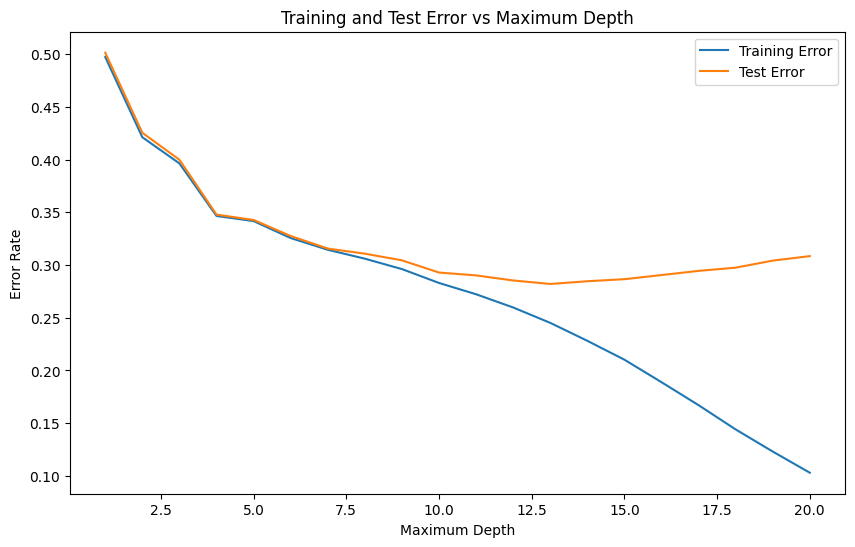

In [33]:
runDecisionTree(trainDfPca.drop(columns=[targetColumn]), testDfPca.drop(columns=[targetColumn]), trainDataPriceClass, testDataPriceClass)
plotErrorDecisionTree(trainDfPca.drop(columns=[targetColumn]), testDfPca.drop(columns=[targetColumn]), trainDataPriceClass, testDataPriceClass)

<span style="color:cyan;">

**max_depth**=20: Limits how deep the tree can grow, controlling model complexity.

**min_samples_leaf**=20: Sets the minimum samples required in leaf nodes to prevent overfitting.

**min_samples_split**=2: Specifies the minimum samples a node must have to split, avoiding splits that don't add value.

**criterion**='entropy': Measures split quality using entropy, which quantifies information gain.

These parameters tailor the decision tree's structure and decision-making process to balance complexity and accuracy on new data.

</span>

In [34]:
def runXGBoostClassifier(XTrain, XTest, yTrain, yTest):
    model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=19)
    model.fit(XTrain, yTrain)
    yTrainPred = model.predict(XTrain)
    yTestPred = model.predict(XTest)
    
    trainAccuracy = accuracy_score(yTrain, yTrainPred)
    trainPrecision = precision_score(yTrain, yTrainPred, average='weighted')
    trainRecall = recall_score(yTrain, yTrainPred, average='weighted')
    trainF1 = f1_score(yTrain, yTrainPred, average='weighted')
    
    testAccuracy = accuracy_score(yTest, yTestPred)
    testPrecision = precision_score(yTest, yTestPred, average='weighted')
    testRecall = recall_score(yTest, yTestPred, average='weighted')
    testF1 = f1_score(yTest, yTestPred, average='weighted')
    
    print("Training Metrics:")
    print(f"Accuracy: {trainAccuracy:.2f}")
    print(f"Precision: {trainPrecision:.2f}")
    print(f"Recall: {trainRecall:.2f}")
    print(f"F1 Score: {trainF1:.2f}")
    print("\nTest Metrics:")
    print(f"Accuracy: {testAccuracy:.2f}")
    print(f"Precision: {testPrecision:.2f}")
    print(f"Recall: {testRecall:.2f}")
    print(f"F1 Score: {testF1:.2f}")
    print("\nClassification Report (Test Data):")
    print(classification_report(yTest, yTestPred))
    print("Confusion Matrix (Test Data):")
    print(confusion_matrix(yTest, yTestPred))

In [35]:
def plotErrorXGBoost(XTrain, XTest, yTrain, yTest):
    trainErrors = []
    testErrors = []
    maxDepths = range(1, 21)
    for depth in maxDepths:
        model = xgb.XGBClassifier(max_depth=depth, random_state=17, use_label_encoder=False, eval_metric='logloss')
        model.fit(XTrain, yTrain)
        train_accuracy = accuracy_score(yTrain, model.predict(XTrain))
        test_accuracy = accuracy_score(yTest, model.predict(XTest))
        trainErrors.append(1 - train_accuracy)
        testErrors.append(1 - test_accuracy)
    plt.figure(figsize=(10, 6))
    plt.plot(maxDepths, trainErrors, label="Training Error")
    plt.plot(maxDepths, testErrors, label="Test Error")
    plt.xlabel("Maximum Depth")
    plt.ylabel("Error Rate")
    plt.title("Training and Test Error vs Maximum Depth (XGBoost)")
    plt.legend()
    plt.show()

Training Metrics:
Accuracy: 0.85
Precision: 0.85
Recall: 0.85
F1 Score: 0.85

Test Metrics:
Accuracy: 0.84
Precision: 0.84
Recall: 0.84
F1 Score: 0.84

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      9891
           1       0.75      0.77      0.76      9943
           2       0.88      0.87      0.87      9974

    accuracy                           0.84     29808
   macro avg       0.84      0.84      0.84     29808
weighted avg       0.84      0.84      0.84     29808

Confusion Matrix (Test Data):
[[8609 1240   42]
 [1063 7702 1178]
 [  16 1324 8634]]


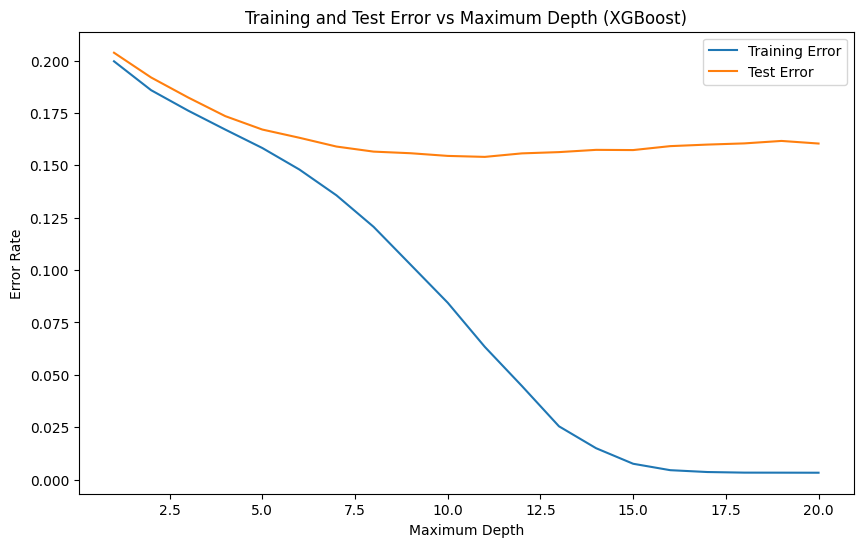

In [36]:
mapping = {"Low": 0, "Medium": 1, "High": 2}
runXGBoostClassifier(trainDf.drop(columns=[targetColumn]), testDf.drop(columns=[targetColumn]), trainDataPriceClass.replace(mapping), testDataPriceClass.replace(mapping))
plotErrorXGBoost(trainDf.drop(columns=[targetColumn]), testDf.drop(columns=[targetColumn]), trainDataPriceClass.replace(mapping), testDataPriceClass.replace(mapping))

Training Metrics:
Accuracy: 0.75
Precision: 0.75
Recall: 0.75
F1 Score: 0.75

Test Metrics:
Accuracy: 0.73
Precision: 0.73
Recall: 0.73
F1 Score: 0.73

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.84      0.78      0.81      9891
           1       0.63      0.62      0.62      9943
           2       0.74      0.80      0.77      9974

    accuracy                           0.73     29808
   macro avg       0.73      0.73      0.73     29808
weighted avg       0.73      0.73      0.73     29808

Confusion Matrix (Test Data):
[[7714 1793  384]
 [1349 6168 2426]
 [ 158 1861 7955]]


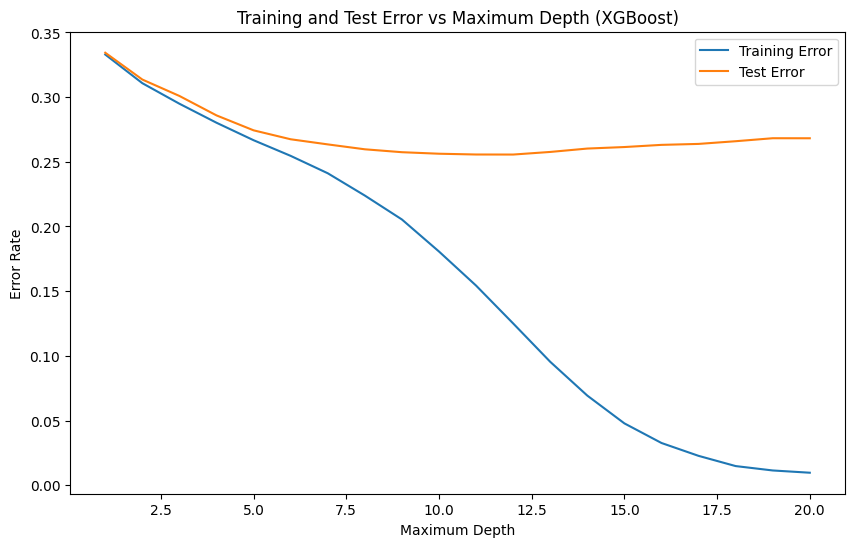

In [37]:
runXGBoostClassifier(trainDfPca.drop(columns=[targetColumn]), testDfPca.drop(columns=[targetColumn]), trainDataPriceClass.replace(mapping), testDataPriceClass.replace(mapping))
plotErrorXGBoost(trainDfPca.drop(columns=[targetColumn]), testDfPca.drop(columns=[targetColumn]), trainDataPriceClass.replace(mapping), testDataPriceClass.replace(mapping))

<font color='cyan'>

use_label_encoder=False: Accepts non-integer labels directly without internal encoding.

eval_metric='mlogloss': Evaluates model performance using Multiclass Logarithmic Loss.

random_state=19: Sets the seed for random number generation to maintain result consistency.

</font>

<font color='cyan'>
Because our results are equally important, the metric that holds the most significance for us is the F1 score, as it balances precision and recall, aligning with our objective.
</font>

<font color='cyan'>

### Analysis:

- **XGBoost Regressor** (90%): This method achieved the highest score among all models, indicating that it performed the best in terms of predictive accuracy for regression tasks. XGBoost is known for its strong performance in structured data scenarios, often outperforming traditional linear models like Linear Regression and Decision Trees.

- **CNN** (around 87%): Convolutional Neural Networks typically excel in tasks involving images or sequential data, such as natural language processing. Achieving 87% suggests it performed very well, likely due to its ability to capture complex patterns in the data.

- **XGBoost Classifier** (about 84%): This model also performed well, though slightly lower than the XGBoost Regressor. XGBoost as a classifier is effective for classification tasks due to its ensemble nature and ability to handle complex interactions in features.

- **Decision Tree** (about 82%): Decision Trees are straightforward yet powerful models, but they can sometimes overfit or underfit depending on hyperparameters and data characteristics. Achieving around 80% suggests decent performance but not as high as the ensemble methods like XGBoost.

- **Linear Regression** (about 76%): Linear Regression is a basic yet interpretable model suitable for regression tasks. Its lower score compared to more complex models like XGBoost indicates that the dataset may have nonlinear relationships or interactions that Linear Regression cannot capture effectively.

### Conclusion:

- **Best Performing Method**: Based on the provided scores, the **XGBoost Regressor** achieved the highest accuracy at 90%. This makes it the top performer among the listed methods for the regression task.

- **Considerations**: The choice of the best method depends on various factors such as the specific nature of the data, computational efficiency requirements, interpretability, and the trade-off between bias and variance. XGBoost models generally offer robust performance across different types of datasets but may require more computational resources compared to simpler models like Linear Regression or Decision Trees.

</font>

## <span style="color: orange;">**Part 6: Feature Analysis**</span>

<span style="color: cyan;">As you can see in the previous section, we trained every model on a data frame with PCA applied, and in all cases, the results for the data frame with PCA are much lower than those for the original data frame. This is because when using only 2 principal components for PCA, only about 51% of the variance is retained. To retain 95% of the variance, we would need to use 6 principal components. Therefore, it makes sense that our results with PCA are significantly lower.</span>

## <span style="color: orange;">**Part 7: Overall Report and Discussions**</span>

###  <span style="color: pink;"> Phase 0: </span>

<span style="color: cyan;">
Initially, we aimed to analyze house prices because we found it interesting. Therefore, we searched various websites for a relatively comprehensive dataset for houses and eventually found this dataset.
</span>

### <span style="color: pink;"> Phase 1: </span>

<span style="color: cyan;">

First, we performed preprocessing, handling missing data and translating words in some columns that were in Chinese. After completing preprocessing, we displayed some interesting aspects of the dataset. After these analyses, we discovered that the columns `communityAverage` and `tradeTimeYear` are related to our target column. We also found that proximity to the city center and urban areas (district) positively impacts the target column.

</span>

### <span style="color: pink;"> Phase 2: </span>

<span style="color: cyan;">

At the beginning of this phase, we carried out some preprocessing tasks that were not necessary in Phase 1. Then, in the feature engineering part, we created some new features like `distanceToCenter` and `districtLevel`, which had a relatively good relationship with the target column. Next, as described in the instructions, we used PCA to reduce the dimensions of the numerical features and found that to retain 95% of the variance, we need 6 dimensions, and 2 dimensions are not sufficient.

In the subsequent section, we explained the metrics we considered for model evaluation. Since our task was not classification, we used metrics like R² Score and RMSE. Following the instructions, we trained models like CNN, Linear Regression, and Decision Tree on the dataset. The evaluation results on the test data were relatively good, but since we were aiming for better accuracy, we also implemented XGBoostClassifier and XGBoostRegressor models. The best result was obtained from the XGBoostRegressor model.

In the final step, we compared the results between the original dataset and the dataset with PCA. As expected, the results for the original dataset were better because in the dataset with PCA, only about 51% of the variance was retained.
</span>